In [1]:
import pandas as pd
import numpy as np
import missingno as msno 
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import scikitplot as skplt
import matplotlib.pyplot as plt
import sklearn.metrics as m
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from bayes_opt import BayesianOptimization
import plotly.graph_objs as go
from xgboost import plot_importance, plot_tree


# Conteúdo

* [<font size=4>Exploração dos dados</font>](#1)
    
* [<font size=4>Treinamento</font>](#2)
    * [XGBoost ](#2.1)
    * [CatBoost ](#2.2)
    * [Regressão Logística](#2.3)
    * [Teste de Calibração](#2.4)

* [<font size=4>Avaliação</font>](#3)
    * [Estatística KS](#3.1)
    * [Curva ROC](#3.2)
    * [Curva Lift](#3.3)
    * [Métricas para bases desbalanceadas](#3.4)

* [<font size=4>Falsos negativos custem 10x mais caros que falsos positivos</font>](#4)
* [<font size=4>Curva de Lucro</font>](#5)
* [<font size=4>Rápido tempo de inferência</font>](#6)

### Exploração dos dados <a id="1"></a>

In [50]:
df = pd.read_csv('dados.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   a       150000 non-null  int64  
 1   b       137016 non-null  float64
 2   c       137016 non-null  float64
 3   d       149635 non-null  float64
 4   e       150000 non-null  float64
 5   f       149989 non-null  float64
 6   g       149806 non-null  object 
 7   h       150000 non-null  int64  
 8   i       150000 non-null  object 
 9   j       150000 non-null  object 
 10  k       150000 non-null  float64
 11  l       149989 non-null  float64
 12  m       149635 non-null  float64
 13  n       150000 non-null  int64  
 14  o       41143 non-null   object 
 15  p       150000 non-null  object 
 16  fecha   150000 non-null  object 
 17  monto   150000 non-null  float64
 18  score   150000 non-null  int64  
 19  fraude  150000 non-null  int64  
dtypes: float64(9), int64(5), object(6)
memory usage:

In [51]:
df.head(15)

a       b          c     d         e     f   g   h  \
0   4  0.7685   94436.24  20.0  0.444828   1.0  BR   5   
1   4  0.7550    9258.50   1.0  0.000000  33.0  BR   0   
2   4  0.7455  242549.09   3.0  0.000000  19.0  AR  23   
3   4  0.7631   18923.90  50.0  0.482385  18.0  BR  23   
4   2  0.7315    5728.68  15.0  0.000000   1.0  BR   2   
5   4  0.7359   42727.15  50.0  0.000000  47.0  BR   1   
6   4  0.5962    7121.78   2.0  0.398000   0.0  BR  11   
7   4  0.6806    1656.95  50.0  1.043077   0.0  BR  11   
8   4  0.5893  311762.23   6.0  0.000000  15.0  AR   2   
9   4  0.4759   40143.12  50.0  0.000000  41.0  AR   3   
10  4  0.8353  121926.06  39.0  0.186957  34.0  BR  24   
11  4  0.7206  227874.02   1.0  0.230960   0.0  BR   8   
12  4  0.7688  440434.49  50.0  0.000000  78.0  BR  17   
13  4  0.7921    6555.99  50.0  0.447612  18.0  BR   9   
14  4  0.7702     706.47   1.0  0.153675   9.0  BR   7   

                                                    i            j         k  \
0   Máquininha Corta Barba Cabelo Peito Perna Pelo...  cat_8d714cd  0.883598   
1   Avental Descartavel Manga Longa  - 50 Un. Tnt ...  cat_64b574b  0.376019   
2   Bicicleta Mountain Fire Bird Rodado 29 Alumini...  cat_e9110c5  0.516368   
3   Caneta Delineador Carimbo Olho Gatinho Longo 2...  cat_d06e653  0.154036   
4            Resident Evil Operation Raccoon City Ps3  cat_6c4cfdc  0.855798   
5          Kit Gamer Teclado Hedfone Mouse E Mousepad  cat_9d78e2e  0.571502   
6   Corpinho Avulso Joseph, Josepha Ou Placa Sem Sexo  cat_5d6059e  0.204991   
7    Tripa Para Fazer Linguiça - 45 Metros Long Short  cat_e686ce3  0.569230   
8   Soldadora Inverter 180 A + Máscara + 2 Esc. Ma...  cat_bfe5d9b  0.897001   
9   Gamepad Joystick Para Telefono Celular Android...  cat_5d79fb9  0.735790   
10  Escova Dental Curaprox 5460 Ultra Soft Com 3 U...  cat_4744ece  0.943792   
11  Par Lanterna Luz De Placa C/ Led Fiat 500 Cone...  cat_768556e  0.530758   
12  Câmera Sony Mirrorless Alpha A6500 (corpo) Gar...  cat_d3aa8de  0.618222   
13  Filtro Ar Motor Audi A3 Vw Golf Mk7 Após 2012 ...  cat_ca18469  0.132371   
14      Base Alta Cobertura Nº4 Bege Essenze Di Pozzi  cat_708c94b  0.269991   

         l       m  n    o  p                fecha    monto  score  fraude  
0    240.0   102.0  1  NaN  N  2020-03-27 11:51:16     5.64     66       0  
1   4008.0     0.0  1    Y  N  2020-04-15 19:58:08   124.71     72       0  
2   1779.0    77.0  1  NaN  N  2020-03-25 18:13:38   339.32     95       0  
3   1704.0  1147.0  1  NaN  Y  2020-04-16 16:03:10     3.54      2       0  
4   1025.0   150.0  1  NaN  N  2020-04-02 10:24:45     3.53     76       0  
5   2798.0   506.0  1  NaN  Y  2020-04-13 18:42:28    28.00     32       0  
6    127.0   125.0  0  NaN  N  2020-03-22 19:20:24    10.56     71       0  
7    363.0   224.0  0  NaN  N  2020-04-12 11:49:54     6.13     81       0  
8   4661.0   826.0  1    Y  Y  2020-04-20 22:58:52   142.71     64       0  
9   4701.0   940.0  1  NaN  Y  2020-03-11 15:06:38    30.48     60       0  
10  3248.0   132.0  1    Y  Y  2020-03-15 19:18:50    14.85     10       0  
11  2640.0     0.0  1  NaN  N  2020-04-19 17:07:37    23.79     24       0  
12  4970.0  1580.0  1  NaN  Y  2020-03-16 11:49:05  1138.64     83       0  
13  5513.0  1060.0  1    Y  Y  2020-04-02 22:30:29     7.89     50       0  
14  3199.0     0.0  1  NaN  N  2020-03-20 15:42:14     9.19     60       0

In [ ]:
# Análise de correlações
# Análise de distribuições categóricas e numéricas
# Avaliar outliers
# embedding do nome do produto


In [52]:
import datetime as dt
df = df.assign(fecha = df.fecha.apply(lambda x:dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")),
               c = np.log(df.c))
df = df.assign(hora = df.fecha.dt.hour+df.fecha.dt.minute/60)
df

As colunas b,c e o contém dados faltantes,  mas vamos mantê-las, já que a quantidade de dados faltantes não é comprometedora para a perfomance dos modelos de machine learning.

<Axes: >

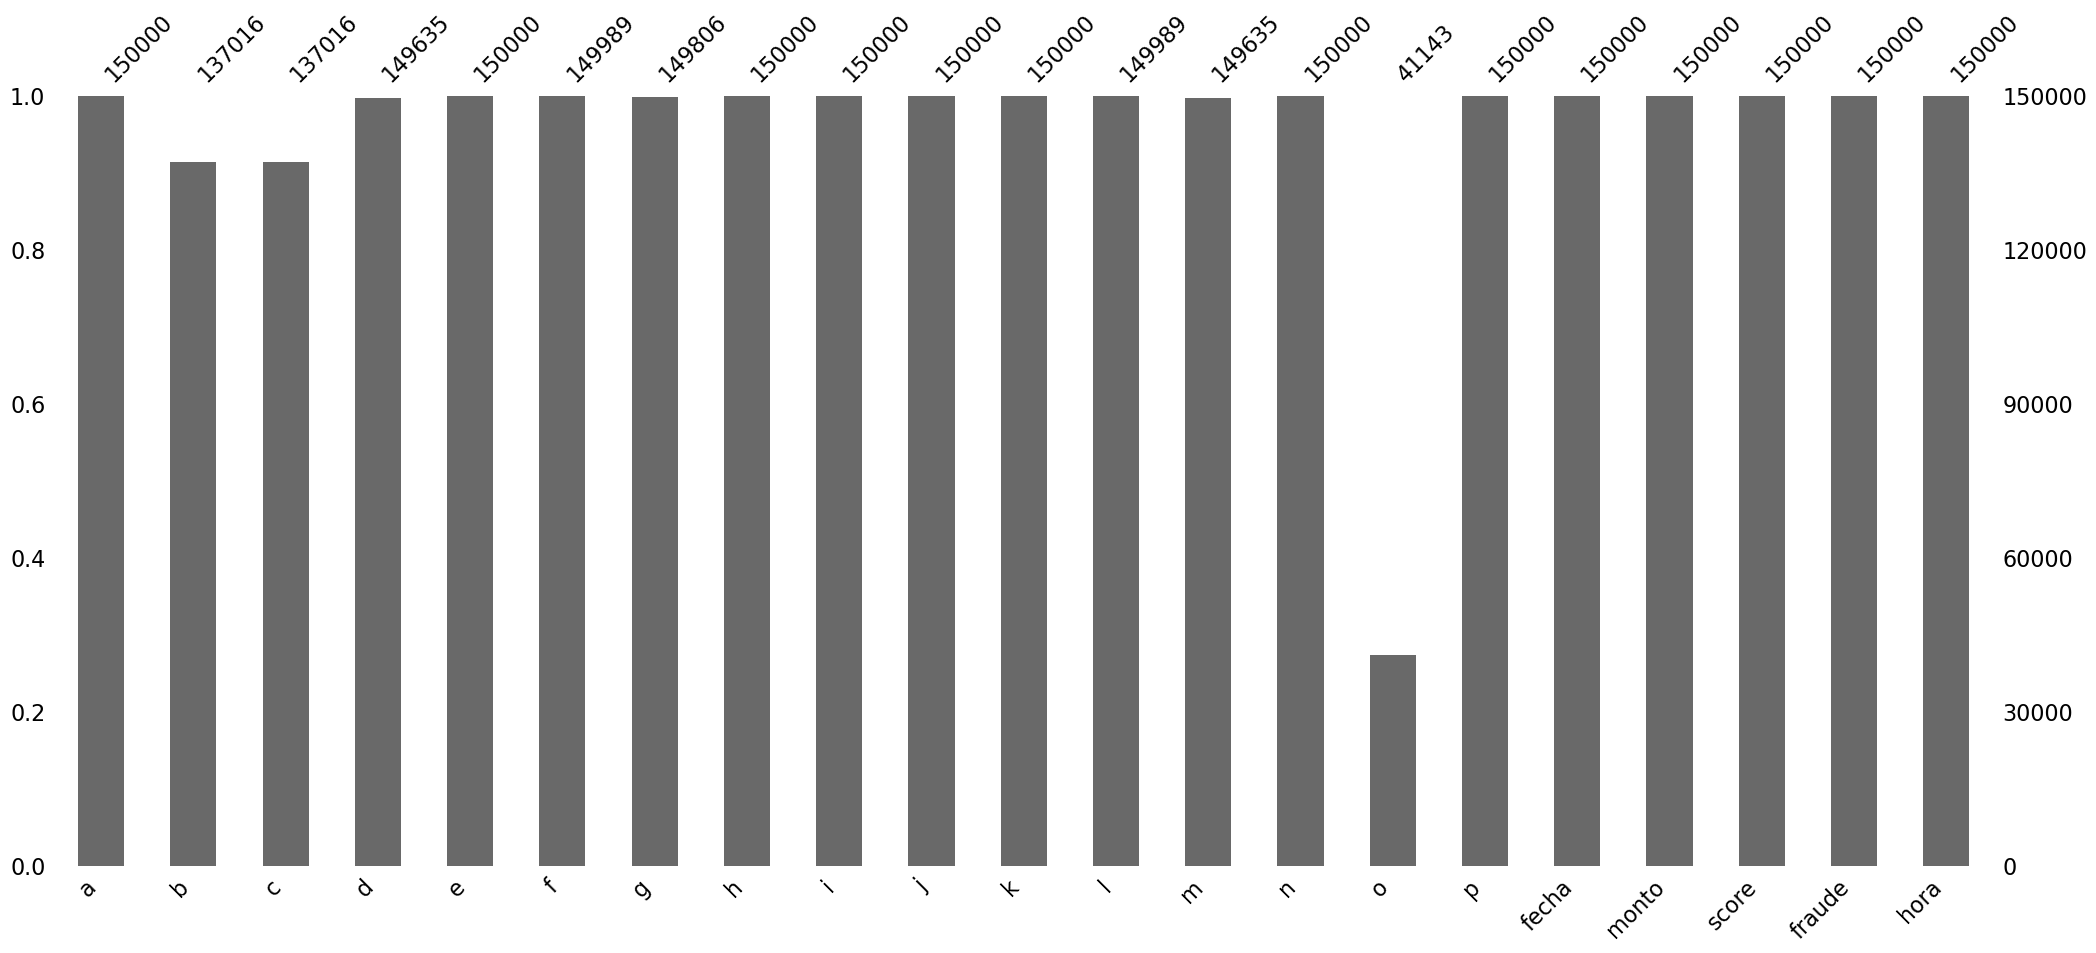

In [62]:
msno.bar(df)

É comum que as bases de treinamento de fraudes exibam desequilíbrio, o que pode afetar a eficácia dos modelos de detecção. Nesse contexto, diversos métodos de oversampling e undersampling podem ser empregados para lidar com esse desafio, buscando garantir uma representação adequada das classes. Considerando que uma proporção de 5% não é considerada prejudicial, podemos adotar estratégias para ajustar os pesos dos modelos, visando mitigar o impacto do desbalanceamento e melhorar a capacidade de identificação de fraudes de forma mais precisa e eficiente.

label 0: 95.0 % of datapoints
label 1: 5.0 % of datapoints


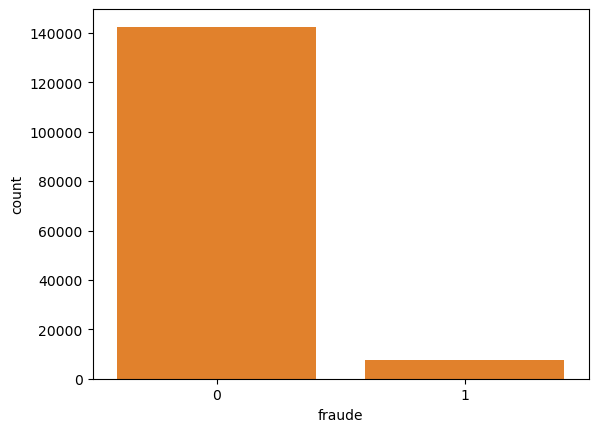

In [63]:
print('label 0:', round(
        df['fraude'].value_counts()[0]/len(df)*100, 2), '% of datapoints')
print('label 1:', round(
        df['fraude'].value_counts()[1]/len(df)*100, 2), '% of datapoints')
sns.countplot(df, x="fraude")

sns.countplot(df, x="fraude");

### Treinamento <a id="2"></a>

#### Melhores práticas 
Para treinamento, as etapas seguidas foram:

1. **Divisão Estratificada dos Dados**: Isso é crucial para garantir que o modelo seja treinado em um conjunto de dados que represente adequadamente a distribuição dos dados de produção. Se houver desequilíbrio entre as classes, a divisão estratificada ajudará a evitar viés nos conjuntos de treinamento e teste.

2. **Validação Cruzada (Cross-Validation)**: A validação cruzada é uma técnica que divide os dados em múltiplos conjuntos de treinamento e validação, permitindo avaliar o desempenho do modelo de forma mais robusta e reduzindo a dependência da divisão dos dados

3. **Ajuste de Hiperparâmetros (Tuning)**: O ajuste de hiperparâmetros envolve a seleção dos melhores valores para os parâmetros do modelo. Nesse projeto foi utilizado otimização bayesiana para tuning. O ajuste de hiperparâmetros ajuda a encontrar a configuração ótima do modelo, maximizando seu desempenho nos dados de treinamento e validação.

4. **Avaliação Final na Base de Teste**: Após o ajuste de hiperparâmetros e a validação cruzada, é crucial avaliar o desempenho do modelo em um conjunto de dados de teste independente. Este conjunto de dados de teste deve ser mantido isolado durante todo o desenvolvimento do modelo e só deve ser usado uma vez para avaliar o desempenho final do modelo. Isso ajuda a verificar se o desempenho observado durante o desenvolvimento do modelo é generalizável e representa adequadamente o desempenho esperado em produção.

####  E se o desempenho for diferente do esperado?

Se, mesmo seguindo as práticas acima, o desempenho do modelo for diferente, a causa mais provável é que os dados de treinamento não refletem apropriadamento os dados de produção. Aqui estão algumas das possíveis causas a serem consideradas:

1. **Dados de entrada não representativos**: Os dados de entrada na produção podem diferir significativamente dos dados de treinamento, levando a uma má generalização do modelo. Isso pode ocorrer devido a mudanças nas distribuições dos dados ao longo do tempo ou diferenças entre os ambientes de treinamento e produção.


2. **Falha na engenharia de features**: As features usadas para treinar o modelo podem não capturar adequadamente as informações relevantes nos dados de produção. Pode ser necessário revisar e aprimorar a engenharia de features.

3. **Dados ausentes ou corrompidos**: A presença de dados ausentes ou corrompidos na produção pode afetar adversamente o desempenho do modelo, especialmente se o modelo não foi projetado para lidar com esses casos.

4. **Mudança de distribuição**: Se a distribuição dos dados de produção for significativamente diferente da dos dados de treinamento, o modelo pode não generalizar bem para a nova distribuição.



In [64]:
y_pre = df['score']/100
vars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n',
       'o', 'p', 'monto', 'hora']

X = df[vars]
y = df['fraude']

X_train, X_test, y_train, y_test, _, y_hat_prev = train_test_split(X, y, y_pre, test_size=0.2, stratify=y, random_state=42)

In [65]:
class Train_model:
    def __init__(self, X: pd.DataFrame, y:pd.Series, default_params: dict, positive_weight: int=1):
        self.X = X
        self.y = y
        self.default_params = default_params
        self.y_weighted = [positive_weight if label == 1 else 1 for label in y]

    def _xgb_evaluate(
        self,
        max_depth,
        learning_rate,
        subsample,
        colsample_bytree,
        n_estimators,
        min_child_weight,
        gamma,
    ):
        
        params = {
            "max_depth": int(max_depth),
            "learning_rate": learning_rate,
            "subsample": subsample,
            "colsample_bytree": colsample_bytree,
            "n_estimators": int(n_estimators),
            "min_child_weight": min_child_weight,
            "gamma": gamma,
        }
        model = XGBClassifier(**params, **self.default_params)
        cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)
        cv_score = cross_val_score(model, self.X, self.y.ravel(), cv=cv, scoring="roc_auc", params={'sample_weight':self.y_weighted})
        return cv_score.mean()

    def _cat_evaluate(
        self, depth, learning_rate, colsample_bylevel, min_data_in_leaf
    ):
        params = {
            "depth": int(depth),
            "learning_rate": learning_rate,
            "colsample_bylevel": colsample_bylevel,
            "min_data_in_leaf": int(min_data_in_leaf),
        }
        model = CatBoostClassifier(
            **params,
            **self.default_params
        )

        cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)
        cv_score = cross_val_score(model, self.X, self.y.ravel(), cv=cv, scoring="roc_auc", params={'sample_weight':self.y_weighted})
        return cv_score.mean()

    def _log_reg_evaluate(self, C):
        params = {
            "C": C,
        }
        model = LogisticRegression(**params, **self.default_params)
        cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)
        cv_score = cross_val_score(model, self.X, self.y, cv=cv, scoring="roc_auc", params={'sample_weight':self.y_weighted})
        return cv_score.mean()

    def fit(self, model_name="xgboost", n_iter=20):

        if model_name == "xgboost":
            print("Finding best parameters... {}".format(pd.Timestamp.now()))
            xgb_bo = BayesianOptimization(
                self._xgb_evaluate,
                {
                    "max_depth": (3, 20),
                    "learning_rate": (0.001, 0.3),
                    "subsample": (0.2, 1.0),
                    "colsample_bytree": (0.2, 1.0),
                    "n_estimators": (50, 500),
                    "min_child_weight": (1.0, 20.0),
                    "gamma": (0, 1.0),
                },
            )
            xgb_bo.maximize(init_points=5, n_iter=n_iter)
            best_params: dict = xgb_bo.max["params"]  # type: ignore
            best_params["max_depth"] = int(best_params["max_depth"])
            best_params["n_estimators"] = int(best_params["n_estimators"])

            print("Fitting model... {}".format(pd.Timestamp.now()))
            new_xgb_classifier = XGBClassifier(**best_params, **self.default_params)
            # xgb_classifier_c = CalibratedClassifierCV(new_xgb_classifier,
            #                                          method='sigmoid', cv=3)
            # xgb_classifier_c.fit(self.X, self.y)
            return new_xgb_classifier.fit(self.X, self.y, sample_weight = self.y_weighted)

        if model_name == "catboost":
            print("Finding best parameters... {}".format(pd.Timestamp.now()))
            xgb_bo = BayesianOptimization(
                self._cat_evaluate,
                {
                    "depth": (1, 15),
                    "learning_rate": (0.001, 0.3),
                    "colsample_bylevel": (0.05, 1.0),
                    "min_data_in_leaf": (1, 100),
                },
            )
            xgb_bo.maximize(init_points=5, n_iter=n_iter)
            best_params: dict = xgb_bo.max["params"]  # type: ignore
            best_params["depth"] = int(best_params["depth"])
            best_params["min_data_in_leaf"] = int(best_params["min_data_in_leaf"])

            print("Fitting model... {}".format(pd.Timestamp.now()))
            new_cat_classifier = CatBoostClassifier(
                **best_params,
                **self.default_params
            )
            # xgb_classifier_c = CalibratedClassifierCV(new_xgb_classifier,
            #                                          method='sigmoid', cv=3)
            # xgb_classifier_c.fit(self.X, self.y)
            return new_cat_classifier.fit(self.X, self.y, sample_weight = self.y_weighted)

        if model_name == "logistic_regression":
            print("Finding best parameters... {}".format(pd.Timestamp.now()))
            log_reg_bo = BayesianOptimization(self._log_reg_evaluate, {"C": (0.1, 20)})
            log_reg_bo.maximize(init_points=5, n_iter=n_iter)
            best_params: dict = log_reg_bo.max["params"]  # type: ignore

            print("Fitting model... {}".format(pd.Timestamp.now()))
            new_lr_classifier = LogisticRegression(**best_params, **self.default_params)
            return new_lr_classifier.fit(self.X, self.y, sample_weight = self.y_weighted)

### XGBoost <a id="2.1"></a>

XGBoost é conhecido por seu desempenho superior em comparação com muitos outros algoritmos de aprendizado de máquina. 

**Regularização Incorporada**: XGBoost inclui mecanismos de regularização que ajudam a evitar o sobreajuste (overfitting) e melhoram a generalização do modelo. Isso inclui penalidades para a complexidade do modelo e a importância relativa das características.

**Manipulação Eficiente de Dados Ausentes**: XGBoost tem uma maneira eficiente de lidar com dados ausentes. Ele pode automaticamente aprender a melhor maneira de lidar com os valores faltantes, sem a necessidade de pré-processamento adicional.

**Interpretabilidade**: XGBoost fornece ferramentas para interpretar o modelo, como importância de características (feature importance) e visualizações de árvores de decisão, o que pode ajudar a entender como o modelo está fazendo previsões.

O pre-processamento é simples, Xgboost consegue lidar com dados faltantes e categóricos. Além disso, por ser um modelo baseado em árvores, não é necessário normalizar dados numéricos.

In [66]:
def pre_xgb(df):
    df = df.assign(g = lambda x: x.g.astype('category'),
                    o = lambda x: x.o.astype('category'),
                    p = lambda x: x.p.astype('category'),
                    j = lambda x: x.j.astype('category')
                    )
    return df


X_train_xgb = pre_xgb(X_train)
X_test_xgb = pre_xgb(X_test)

In [67]:
X_train_xgb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120000 entries, 40222 to 1534
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   a       120000 non-null  int64   
 1   b       109644 non-null  float64 
 2   c       109644 non-null  float64 
 3   d       119702 non-null  float64 
 4   e       120000 non-null  float64 
 5   f       119993 non-null  float64 
 6   g       119843 non-null  category
 7   h       120000 non-null  int64   
 8   j       120000 non-null  category
 9   k       120000 non-null  float64 
 10  l       119993 non-null  float64 
 11  m       119702 non-null  float64 
 12  n       120000 non-null  int64   
 13  o       32878 non-null   category
 14  p       120000 non-null  category
 15  monto   120000 non-null  float64 
 16  hora    120000 non-null  float64 
dtypes: category(4), float64(10), int64(3)
memory usage: 13.7 MB


In [68]:
n0, n1 = np.bincount(y_train)
scale_pos_weight = n0/n1

default_xgb_params = {
            "n_jobs": -1,
            "enable_categorical": True,
            "use_label_encoder": False,
            "tree_method": "hist",
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "device":"cuda",
            "scale_pos_weight": scale_pos_weight
        }
xgboost = Train_model(X_train_xgb, y_train, default_xgb_params).fit(model_name='xgboost', n_iter=50)

Finding best parameters... 2024-04-01 17:25:17.029630
|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------


c:\Users\bruno\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:25:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


| 1         | 0.8131    | 0.9728    | 0.2768    | 0.1453    | 12.68     | 10.67     | 437.3     | 0.9273    |
| 2         | 0.8053    | 0.9917    | 0.8396    | 0.2556    | 13.33     | 16.42     | 277.3     | 0.8049    |
| 3         | 0.8095    | 0.362     | 0.9927    | 0.2203    | 8.207     | 15.52     | 300.2     | 0.6368    |
| 4         | 0.8323    | 0.268     | 0.897     | 0.1169    | 8.252     | 16.92     | 273.8     | 0.9266    |
| 5         | 0.7891    | 0.7281    | 0.05567   | 0.2538    | 7.824     | 8.474     | 390.4     | 0.3091    |
| 6         | 0.8298    | 0.3328    | 0.5958    | 0.2655    | 7.628     | 5.839     | 54.87     | 0.7692    |
| 7         | 0.8147    | 0.6439    | 0.3926    | 0.2085    | 6.306     | 1.432     | 87.22     | 0.4595    |
| 8         | 0.8227    | 0.8551    | 0.4128    | 0.2109    | 4.912     | 9.634     | 373.0     | 0.6124    |
| 9         | 0.8378    | 0.88      | 0.8623    | 0.05805   | 18.78     | 15.34     | 103.2     | 0.571     |
| 10      

In [69]:
y_hat_xgb = xgboost.predict_proba(X_test_xgb)

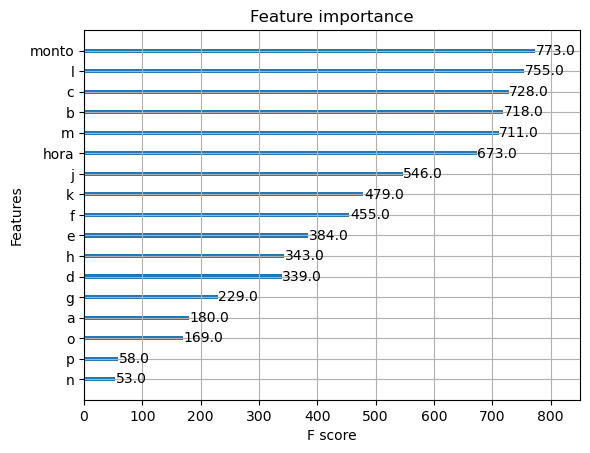

In [70]:
plot_importance(xgboost)
plt.show()

<Figure size 2000x2000 with 0 Axes>

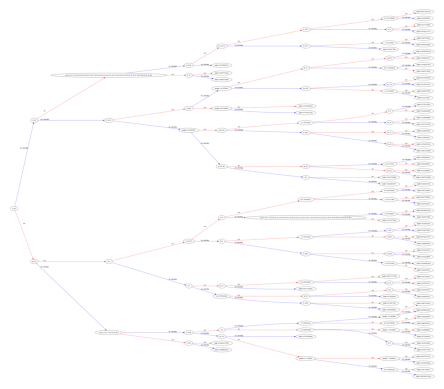

In [71]:
plt.figure(figsize=(20, 20))
plot_tree(xgboost, num_trees=50, rankdir='LR')
plt.savefig('tree_high_res.png', dpi=300)
plt.show()

### Catboost <a id="2.2"></a>

**Eficiente com Dados Categóricos**: Uma das principais vantagens do CatBoost é sua capacidade de lidar automaticamente com variáveis categóricas sem a necessidade de pré-processamento adicional, como codificação one-hot ou codificação de rótulos.

Também possui um pre-processamento simples. A imputação de dados faltantes só é necessária nas colunas categóricas e não exige normalização.

In [72]:
def pre_cat(df):
    df = df.assign(g = lambda x: x.g.fillna('UNKNOW').astype('category'),
                    o = lambda x: x.o.fillna('UNKNOW').astype('category'),
                    p = lambda x: x.p.fillna('UNKNOW').astype('category'),
                    j = lambda x: x.j.fillna('UNKNOW').astype('category')
                    )
    return df

X_train_cat = pre_cat(X_train)
X_test_cat = pre_cat(X_test)

In [73]:
cat_features = ['g', 'o', 'j', 'p']
default_cat_params = {
            "task_type": "CPU",
            "eval_metric": "Logloss",
            "cat_features": cat_features,
            "silent": True,
            "iterations":30,
            "auto_class_weights": "Balanced"
        }

catboost = Train_model(X_train_cat, y_train, default_cat_params).fit(model_name='catboost', n_iter=50)

Finding best parameters... 2024-04-01 17:38:15.367470
|   iter    |  target   | colsam... |   depth   | learni... | min_da... |
-------------------------------------------------------------------------
| 1         | 0.8379    | 0.7413    | 7.914     | 0.05141   | 92.08     |
| 2         | 0.8381    | 0.2596    | 14.58     | 0.2367    | 87.09     |
| 3         | 0.8442    | 0.9619    | 3.925     | 0.1777    | 28.62     |
| 4         | 0.8263    | 0.5176    | 3.598     | 0.04183   | 72.32     |
| 5         | 0.8415    | 0.938     | 3.158     | 0.1304    | 10.72     |
| 6         | 0.8003    | 0.05      | 15.0      | 0.001     | 22.24     |
| 7         | 0.8269    | 0.7184    | 1.181     | 0.147     | 31.71     |
| 8         | 0.8476    | 0.8973    | 4.928     | 0.239     | 8.147     |
| 9         | 0.8216    | 0.6885    | 1.717     | 0.1128    | 4.986     |
| 10        | 0.8448    | 0.8658    | 6.162     | 0.1022    | 10.11     |
| 11        | 0.8475    | 1.0       | 8.693     | 0.3     

In [74]:
y_hat_cat = catboost.predict_proba(X_test_cat)

### Regressão Logística <a id="2.3"></a>

A regressão logística produz resultados que são facilmente interpretáveis. Os coeficientes de regressão podem ser interpretados como o efeito que uma unidade de mudança em uma variável tem na log-odds da variável de resposta.

**Regularização Incorporada**: A regressão logística pode ser regularizada para evitar o overfitting. 

**Previsões Probabilísticas Diretas**: A regressão logística fornece previsões na forma de probabilidades. Isso é útil quando é necessário não apenas prever a classe de uma observação, mas também a probabilidade associada a essa previsão.

para o pre-processamento, é necessário normalizar devido à estabilidade numérica durante o treinamento e com o equilíbrio na escala ajuda o algoritmo de otimização a convergir mais rapidamente e encontrar o mínimo global. Como não lida com dados categóricos, também é necessário convertê-las em variáveis dummies.

In [ ]:
#from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.impute import SimpleImputer
#
#class Preprocessor_lgr(BaseEstimator, TransformerMixin):
#    def __init__(self):
#        self.numeric_columns = None
#        self.scaler = StandardScaler()
#        self.imputer = SimpleImputer(strategy='constant', fill_value='UNKNOW')
#        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
#        
#    def fit(self, X, y=None):
#        self.numeric_columns = X.select_dtypes(include=['int', 'float']).columns
#        self.scaler.fit(X[self.numeric_columns])
#        self.imputer.fit(X[['g', 'o', 'p']])
#        self.encoder.fit(X[['g', 'o', 'p']])
#        return self
#        
#    def transform(self, X):
#        df = X.copy()
#        df_numeric = df.drop(['j', 'g', 'o', 'p'], axis=1)
#        df_numeric[self.numeric_columns] = self.scaler.transform(df_numeric[self.numeric_columns])
#        
#        df_categorical = df[['g', 'o', 'p']].fillna('UNKNOW')
#        df_categorical_encoded = self.encoder.transform(df_categorical)
#        
#        combined_data_encoded = pd.concat([pd.DataFrame(df_numeric), pd.DataFrame(df_categorical_encoded, columns=self.encoder.get_feature_names(['g', 'o', 'p']))], axis=1)
#        return combined_data_encoded

In [75]:
def pre_lgr(df_train, df_test):
    numeric_columns = df_train.select_dtypes(include=['int', 'float']).columns


    scaler = StandardScaler()
    df_train_2 = df_train.drop(['j'], axis=1).copy()
    df_test_2 = df_test.drop(['j'], axis=1).copy()
    df_train_2[numeric_columns] = scaler.fit_transform(df_train_2[numeric_columns])
    df_test_2[numeric_columns] = scaler.fit_transform(df_test_2[numeric_columns])

    combined_data = pd.concat([df_train_2, df_test_2]).assign(g = lambda x: x.g.fillna('UNKNOW').astype('category'),
                        o = lambda x: x.o.fillna('UNKNOW').astype('category'),
                        p = lambda x: x.p.fillna('UNKNOW').astype('category'),
                        )

    combined_data_encoded = pd.get_dummies(combined_data)
    df_train_final = combined_data_encoded[:len(df_train_2)].fillna(-1)
    df_test_final = combined_data_encoded[len(df_train_2):].fillna(-1)
    return df_train_final, df_test_final

X_train_lgr, X_test_lgr = pre_lgr(X_train, X_test)

In [76]:
X_train_lgr.head()

a         b         c         d         e         f         h  \
40222   0.390311 -1.000000 -1.000000 -1.031682 -0.082744 -0.055093  0.340459   
113835  0.390311  0.704951 -0.027905 -0.085073  0.122953 -0.057805 -1.002007   
67288   0.390311 -0.309209 -0.487705  0.114213 -0.082744 -0.025266 -0.295446   
118571  0.390311  0.488115 -0.029311 -0.882218 -0.082744 -0.070007 -0.648726   
5463    0.390311 -2.159845 -0.184468 -0.682931  0.031732 -0.063228  1.117675   

               k         l         m  ...   g_UA  g_UNKNOW   g_US   g_UY  \
40222   1.455759  0.476268 -0.371521  ...  False     False  False  False   
113835  1.555373  1.907778  2.367764  ...  False     False  False  False   
67288   0.368059  0.484445 -0.306152  ...  False     False  False  False   
118571  0.008533 -1.311513 -0.757512  ...  False     False  False  False   
5463    1.374952  0.740259 -0.872686  ...  False     False  False  False   

         g_ZA    o_N  o_UNKNOW    o_Y    p_N    p_Y  
40222   False  False      True  False   True  False  
113835  False  False     False   True  False   True  
67288   False  False      True  False  False   True  
118571  False  False      True  False   True  False  
5463    False   True     False  False   True  False  

[5 rows x 70 columns]

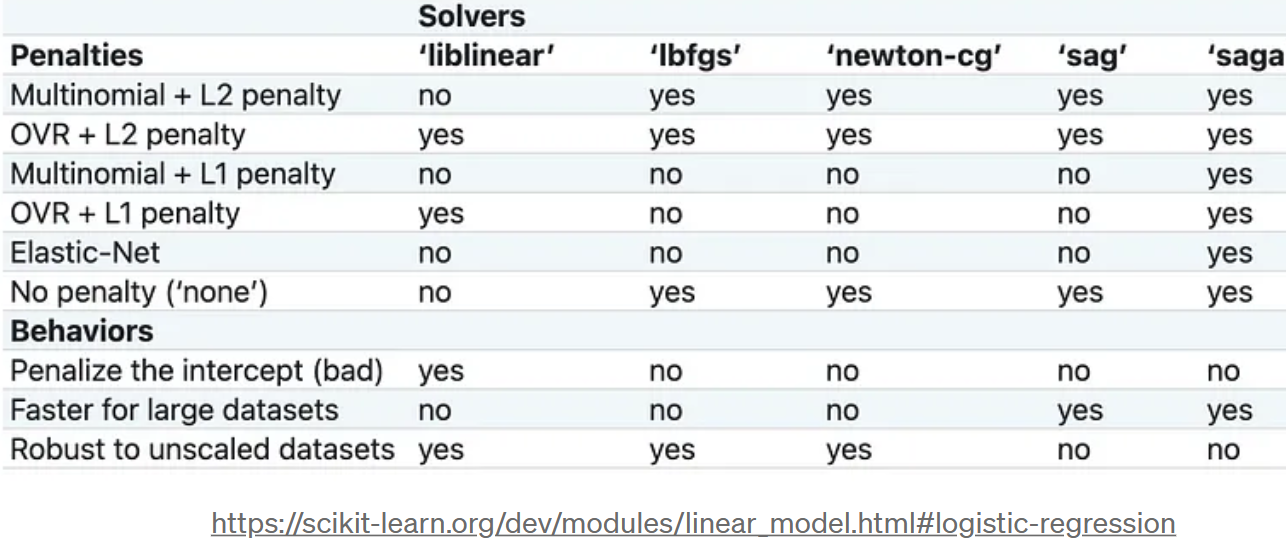

In [77]:
default_lgr_params = {'n_jobs':-1, 
                      'max_iter':1000,
                      'penalty':'l2',
                      'solver':'lbfgs',
                      'class_weight': 'balanced'}


lgr = Train_model(X_train_lgr, y_train, default_lgr_params).fit(model_name='logistic_regression', n_iter=30)

Finding best parameters... 2024-04-01 17:51:46.253072
|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.8328    | 0.3055    |
| 2         | 0.8331    | 2.65      |
| 3         | 0.833     | 0.2725    |
| 4         | 0.8328    | 4.605     |
| 5         | 0.8325    | 8.8       |
| 6         | 0.8327    | 2.706     |
| 7         | 0.8318    | 2.637     |
| 8         | 0.8331    | 19.79     |
| 9         | 0.8327    | 0.2726    |
| 10        | 0.8328    | 12.16     |
| 11        | 0.8331    | 0.2724    |
| 12        | 0.8331    | 0.2715    |
| 13        | 0.8328    | 19.79     |
| 14        | 0.833     | 0.272     |
| 15        | 0.8328    | 2.652     |
| 16        | 0.8329    | 0.2702    |
| 17        | 0.8332    | 0.2709    |
| 18        | 0.8327    | 19.79     |
| 19        | 0.8332    | 2.651     |
| 20        | 0.8324    | 2.649     |
| 21        | 0.833     | 2.65      |
| 22        | 0.8332    | 0.2713    |
| 23        | 0.8327    | 10.37   

In [78]:
y_hat_lgr = lgr.predict_proba(X_test_lgr)

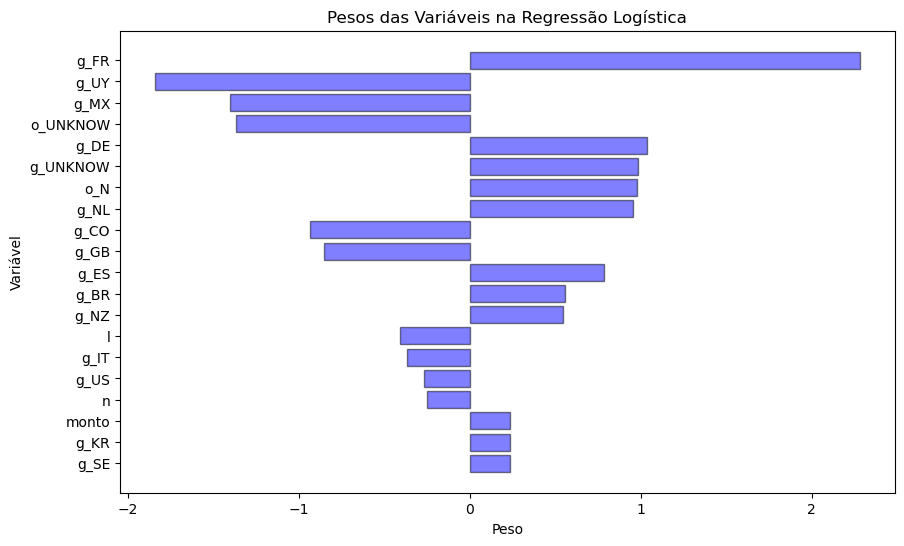

In [79]:
weights = lgr.coef_[0]

# Obter os nomes das variáveis
feature_names = X_train_lgr.columns

sorted_indices = np.argsort(np.abs(weights))[::-1][:20]
sorted_weights = weights[sorted_indices][::-1]
sorted_feature_names = np.array(feature_names)[sorted_indices][:20][::-1]

# Plotar os pesos das variáveis
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_weights, color='blue', alpha=0.5, align='center', edgecolor='black',)
plt.xlabel('Peso')
plt.ylabel('Variável')
plt.title('Pesos das Variáveis na Regressão Logística')
plt.show()

#### Teste de Calibração <a id="2.4"></a>

Modelos baseados em árvores, como árvores de decisão e florestas aleatórias, podem produzir resultados descalibrados devido à sua sensibilidade aos dados de treinamento, limitações na segmentação do espaço de recursos e viés intrínseco para classes majoritárias. 
A regressão logística assume que os dados seguem uma distribuição logística. Se essa suposição não for atendida, os resultados podem ser descalibrados.

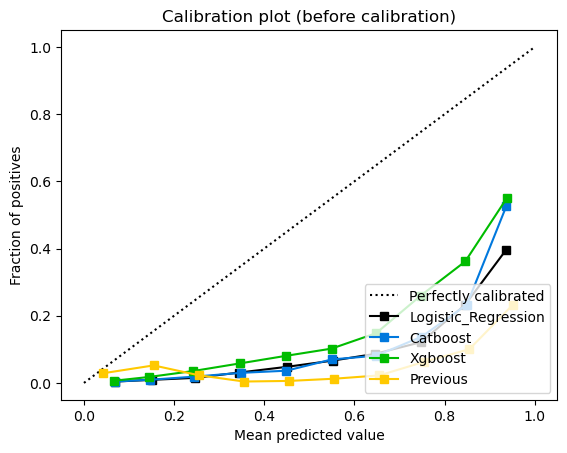

In [80]:
skplt.metrics.plot_calibration_curve(y_test, [y_hat_lgr, y_hat_cat, y_hat_xgb, [[1-i,i] for i in y_hat_prev]], 
                                     ['Logistic_Regression', 'Catboost', 'Xgboost', 'Previous'])
plt.title('Calibration plot (before calibration)');

In [81]:
xgb_classifier_c = CalibratedClassifierCV(xgboost, method='isotonic', cv=3)
catboost_classifier_c = CalibratedClassifierCV(catboost, method='isotonic', cv=3)

y_hat_xgb_c = xgb_classifier_c.fit(X_train_xgb, y_train).predict_proba(X_test_xgb)
y_hat_cat_c = catboost_classifier_c.fit(X_train_cat, y_train).predict_proba(X_test_cat)

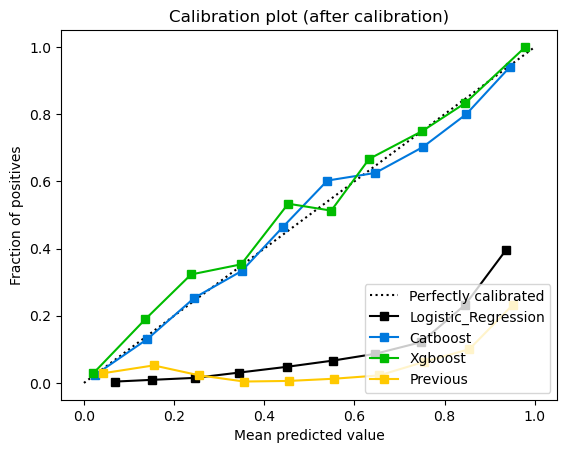

In [82]:
skplt.metrics.plot_calibration_curve(y_test, [y_hat_lgr, y_hat_cat_c, y_hat_xgb_c, [[1-i,i] for i in y_hat_prev]], 
                                     ['Logistic_Regression', 'Catboost', 'Xgboost', 'Previous'])
plt.title('Calibration plot (after calibration)');

### Avaliação <a id="3"></a>

### Estatística KS <a id="3.1"></a>
A estatística KS (Kolmogorov-Smirnov) pode ser útil para comparar duas distribuições de dados relevantes para o problema de detecção de fraudes. A ideia básica por trás do teste KS é comparar as funções de distribuição acumulada (CDF) das duas distribuições. A estatística KS é calculada como a maior diferença absoluta entre as duas CDFs. Quanto maior a estatística KS, maior a diferença entre as duas distribuições.

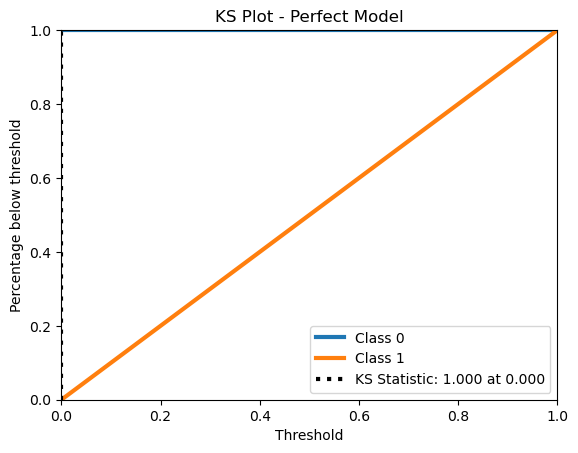

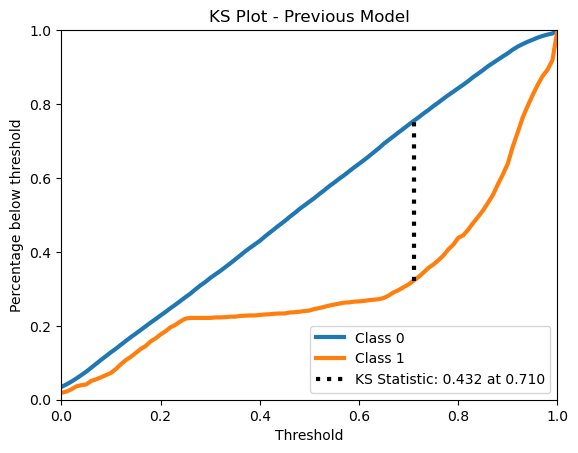

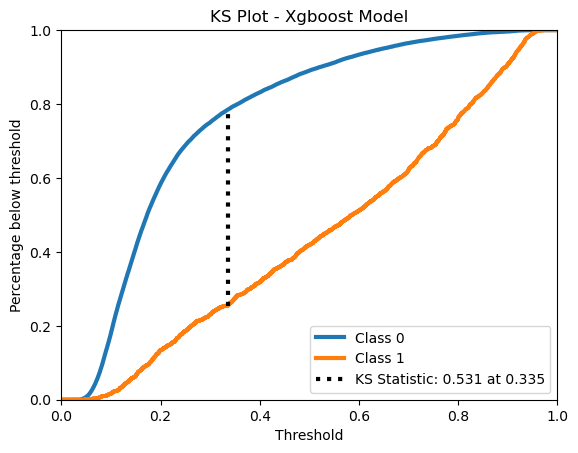

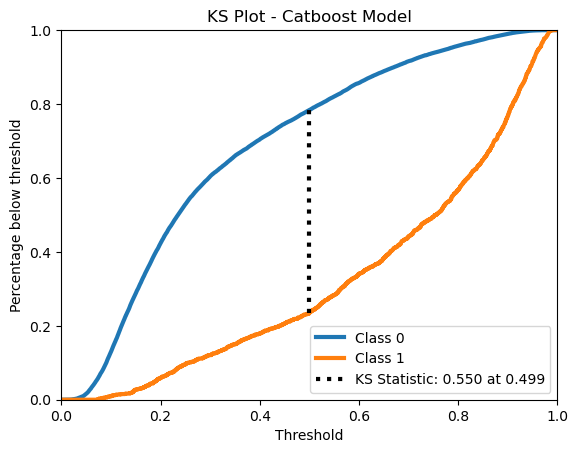

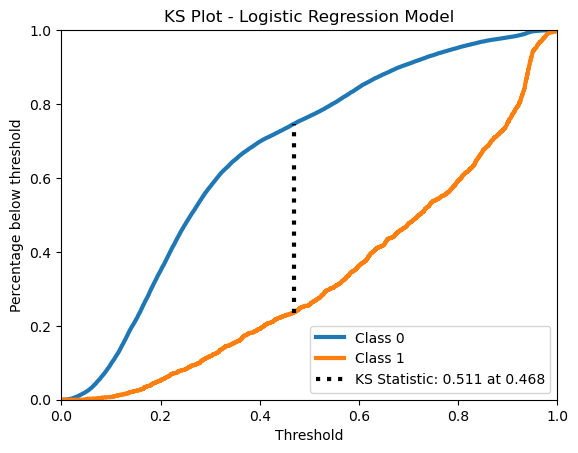

In [83]:
skplt.metrics.plot_ks_statistic(y_test, [[1-i,i] for i in y_test])
plt.title('KS Plot - Perfect Model');
skplt.metrics.plot_ks_statistic(y_test, [[1-i,i] for i in y_hat_prev])
plt.title('KS Plot - Previous Model');
skplt.metrics.plot_ks_statistic(y_test, y_hat_xgb)
plt.title('KS Plot - Xgboost Model');
skplt.metrics.plot_ks_statistic(y_test, y_hat_cat)
plt.title('KS Plot - Catboost Model');
skplt.metrics.plot_ks_statistic(y_test, y_hat_lgr)
plt.title('KS Plot - Logistic Regression Model');

#### Curva ROC <a id="3.2"></a>

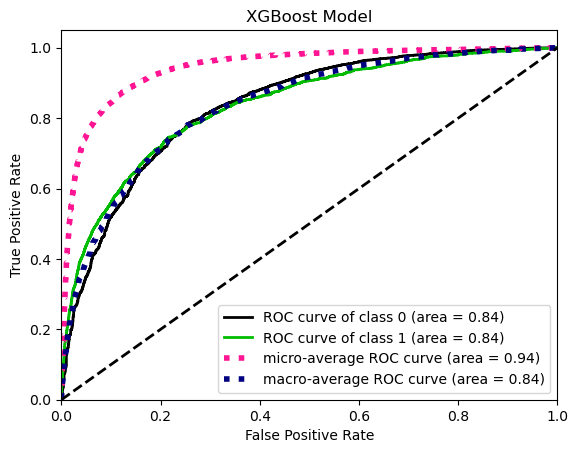

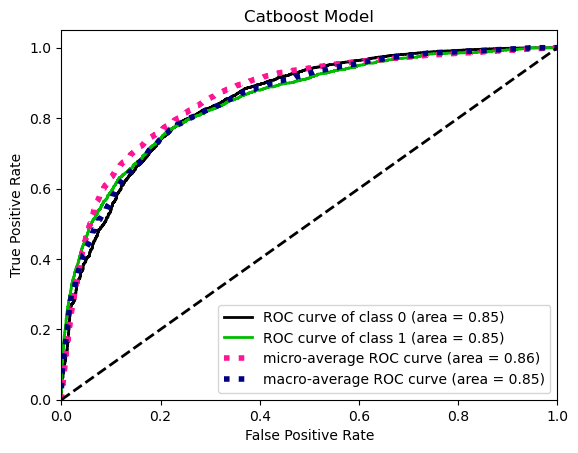

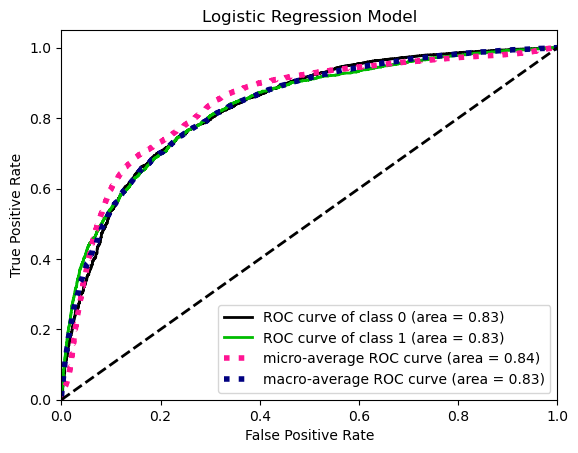

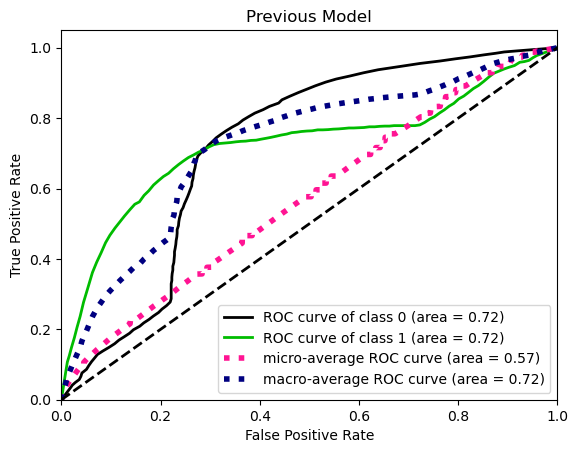

In [84]:
skplt.metrics.plot_roc(y_test, y_hat_xgb)
plt.title('XGBoost Model')
skplt.metrics.plot_roc(y_test, y_hat_cat)
plt.title('Catboost Model')
skplt.metrics.plot_roc(y_test, y_hat_lgr)
plt.title('Logistic Regression Model')
skplt.metrics.plot_roc(y_test, [[1-i,i] for i in y_hat_prev])
plt.title('Previous Model')

plt.show()


#### Curva Lift <a id="3.3"></a>

A curva lift mostra o quanto o modelo está superando uma abordagem de classificação aleatória. Em termos simples, ela compara a taxa de sucesso cumulativa do modelo com a taxa de sucesso esperada ao acaso. Isso significa que o modelo está identificando os casos positivos com mais eficiência do que se estivesse fazendo suposições aleatórias.

In [85]:
import plotly.graph_objs as go

def plot_lift_curve(y_true, y_probs_list, models_name, num_buckets=100):
    """
    Plot a curva Lift.

    Parâmetros:
        y_true (array): Vetor de valores verdadeiros (0s e 1s).
        y_probs_list (list): Lista de vetores de probabilidades previstas para a classe positiva.
        models_name (list): Lista de nomes dos modelos.
        num_buckets (int): Número de intervalos para dividir os dados.
    """
    fig = go.Figure()
    
    for i, y_prob in zip(models_name, y_probs_list):
        # Calcular o número de exemplos positivos
        num_positive_instances = np.sum(y_true)
        
        # Calcular o tamanho do bucket
        bucket_size = len(y_true) / num_buckets
        
        # Ordenar as previsões por probabilidade
        sorted_indices = np.argsort(y_prob)[::-1]
        y_true_sorted = y_true[sorted_indices]
        
        # Calcular o número cumulativo de exemplos positivos em cada bucket
        cumulative_positives = np.cumsum(y_true_sorted)
        
        # Calcular a taxa de elevação (lift) em cada bucket
        lift = cumulative_positives / (np.arange(len(y_true_sorted)) + 1) / (num_positive_instances / len(y_true_sorted))
        
        # Calcular os índices dos buckets
        bucket_indices = np.arange(1, num_buckets + 1) * bucket_size
        
        # Adicionar a curva Lift ao gráfico
        fig.add_trace(go.Scatter(x=bucket_indices[2:], y=lift[2:num_buckets], mode='lines', name=f'{i} Model'))

    # Adicionar a linha de baseline
    fig.add_trace(go.Scatter(x=[1, bucket_indices[-1]], y=[1, 1], mode='lines', name='Baseline', line=dict(dash='dash', color='gray')))
    
    # Layout do gráfico
    fig.update_layout(
        xaxis_title='Número de exemplos',
        yaxis_title='Lift',
        title='Curva Lift',
    )
    
    # Mostrar o gráfico
    fig.show()

# Exemplo de uso
models_name = ['Previous', 'XGBoost', 'Catboost', 'Logistic Regression']

y_true = np.array(y_test)
y_probs_list = [y_hat_prev.values, y_hat_xgb[:, 1], y_hat_cat[:, 1], y_hat_lgr[:, 1]]

plot_lift_curve(y_true, y_probs_list, models_name, num_buckets=30000)

In [86]:
def evaluate(y_true, y_hat):
    roc_auc_score = m.roc_auc_score(y_true, y_hat)
    brier_score = m.brier_score_loss(y_true, y_hat)
    logloss = m.log_loss(y_true, y_hat)
    f5s = []
    cutoffs = np.linspace(0, 1, 20)
    for cutoff in cutoffs:
        predictions = (y_hat > cutoff).astype(int)
        f5s.append(m.fbeta_score(y_true, predictions, beta=5))

    return {'roc_auc_score': roc_auc_score,
                    'brier_score': brier_score,
                    'logloss': logloss,
                    'f5s': max(f5s)}


In [87]:

eval_xgb = evaluate(y_test, y_hat_xgb[:,1])
eval_cat = evaluate(y_test, y_hat_cat[:,1])
eval_lgr = evaluate(y_test, y_hat_lgr[:,1])
eval_prev = evaluate(y_test, y_hat_prev)

list_evals = [eval_prev, eval_xgb, eval_cat, eval_lgr]

#### Métricas para bases desbalanceadas <a id="3.4"></a>


Ao lidar com a detecção de fraudes, é crucial usar métricas de avaliação adequadas que considerem o desbalanceamento dos dados e as consequências dos diferentes tipos de erros. Abaixo estão algumas métricas comumente utilizadas para avaliar modelos de detecção de fraudes:

**ROC AUC (Área Sob a Curva ROC)**

- **Descrição:** A ROC AUC é uma métrica que avalia a capacidade de um modelo classificador distinguir entre as classes positiva e negativa. Representa a área sob a curva ROC, onde a taxa de verdadeiros positivos (sensibilidade) é plotada em função da taxa de falsos positivos (1 - especificidade).
- **Interpretação:** Quanto maior o valor da ROC AUC (que varia de 0 a 1), melhor é a capacidade discriminativa do modelo. Um valor próximo de 1 indica um modelo muito bom em distinguir entre transações legítimas e fraudulentas.

**Brier Score**

$$Brier = \frac{1}{N} \sum_{i=1}^{N} (p_i - y_i)^2 $$

- **Descrição:** O Brier Score é uma medida da média dos quadrados das diferenças entre as previsões de um modelo e os resultados reais. Ele é comumente usado em previsões de eventos binários.
- **Interpretação:** Quanto menor o valor do Brier Score (que varia de 0 a 1), melhor é o desempenho do modelo. Um valor próximo de 0 indica que o modelo faz previsões muito precisas.

**Log Loss (Logarithmic Loss)**

$$LogLoss = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]$$

- **Descrição:** O Log Loss é uma medida da eficácia de um classificador que produz probabilidades de pertencer a uma classe específica em vez de previsões de classe.
- **Interpretação:** Quanto menor o valor do Log Loss, melhor é o desempenho do modelo. Um Log Loss próximo de 0 indica que o modelo está produzindo probabilidades muito próximas das verdadeiras probabilidades.

**F5 Score**

$$F5 = (1 + 5^2) \cdot \frac{{\text{precisão} \cdot \text{recall}}}{{5^2 \cdot \text{precisão} + \text{recall}}}$$

- **Descrição:** O F5 Score é uma versão do F-beta Score, onde beta é igual a 5. Ele combina precisão e recall, com ênfase na sensibilidade (recall).
- **Interpretação:** Um F5 Score mais alto é desejável, indicando um melhor equilíbrio entre precisão e sensibilidade. Ele dá mais peso ao recall do que à precisão, sendo útil em cenários de detecção de fraudes, onde é crucial capturar a maioria das transações fraudulentas, mesmo que isso resulte em mais falsos positivos.

Usar um conjunto de dados desbalanceado de 5% para detecção de fraudes requer uma cuidadosa seleção e interpretação das métricas de avaliação. As métricas mencionadas acima são apenas algumas das muitas opções disponíveis, e a escolha certa dependerá das necessidades específicas do problema e das consequências dos diferentes tipos de erros de classificação.


In [88]:
result = {key: [eval[key] for eval in list_evals] for key in eval_xgb}
pd.DataFrame(result,  index=models_name)

roc_auc_score  brier_score   logloss       f5s
Previous                  0.722568     0.297894  1.166741  0.592460
XGBoost                   0.836153     0.098751  0.340576  0.670423
Catboost                  0.850323     0.149572  0.465475  0.685259
Logistic Regression       0.831194     0.161542  0.503001  0.677440

### Falsos negativos custem 10x mais caros que falsos positivos <a id="4"></a>

Uma abordagem comum para lidar com essa assimetria é atribuir pesos diferentes às amostras durante o treinamento do modelo, de forma que os falsos negativos recebam um peso mais alto em comparação com os falsos positivos. Isso pode ser alcançado através do parâmetro sample_weights no método fit() dos modelos de machine learning.

In [89]:
default_xgb_params = {
            "n_jobs": -1,
            "enable_categorical": True,
            "use_label_encoder": False,
            "tree_method": "hist",
            "objective": "binary:logistic",
            "eval_metric": "auc",
            "device":"cuda",
        }
xgboost_weighted = Train_model(X_train_xgb, y_train, default_xgb_params, positive_weight=10).fit(model_name='xgboost', n_iter=50)

Finding best parameters... 2024-04-01 17:55:37.986805
|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------


| 1         | 0.8013    | 0.9396    | 0.8774    | 0.2928    | 17.89     | 2.283     | 327.2     | 0.593     |
| 2         | 0.7954    | 0.5352    | 0.1389    | 0.1526    | 13.6      | 19.08     | 497.6     | 0.2154    |
| 3         | 0.8329    | 0.7296    | 0.7263    | 0.1959    | 4.096     | 15.48     | 245.1     | 0.4012    |
| 4         | 0.85      | 0.6907    | 0.06166   | 0.02443   | 8.221     | 17.32     | 259.8     | 0.8131    |
| 5         | 0.7932    | 0.8333    | 0.9218    | 0.2515    | 17.57     | 15.52     | 234.4     | 0.434     |
| 6         | 0.8381    | 0.2593    | 0.8048    | 0.2416    | 3.179     | 5.859     | 257.4     | 0.6598    |
| 7         | 0.8314    | 1.0       | 1.0       | 0.004714  | 3.0       | 20.0      | 274.9     | 0.2       |
| 8         | 0.8432    | 0.3506    | 0.2728    | 0.02799   | 18.95     | 10.12     | 269.0     | 0.8879    |
| 9         | 0.837     | 0.9629    | 0.8153    | 0.02802   | 7.322     | 4.11      | 50.07     | 0.3657    |
| 10      

In [90]:
default_cat_params = {
            "task_type": "CPU",
            "eval_metric": "Logloss",
            "cat_features": cat_features,
            "silent": True,
            "iterations":30,
        }
catboost_weighted = Train_model(X_train_cat, y_train, default_cat_params, positive_weight=10).fit(model_name='catboost', n_iter=50)

Finding best parameters... 2024-04-01 18:14:45.260443
|   iter    |  target   | colsam... |   depth   | learni... | min_da... |
-------------------------------------------------------------------------
| 1         | 0.8437    | 0.693     | 7.358     | 0.08677   | 53.92     |
| 2         | 0.8407    | 0.4605    | 13.14     | 0.04674   | 28.47     |
| 3         | 0.8388    | 0.3522    | 14.79     | 0.01915   | 22.51     |
| 4         | 0.8472    | 0.4724    | 10.27     | 0.1382    | 54.13     |
| 5         | 0.8374    | 0.1929    | 6.085     | 0.03562   | 27.04     |
| 6         | 0.8434    | 0.2297    | 14.17     | 0.1918    | 54.64     |
| 7         | 0.8405    | 0.3024    | 10.91     | 0.05989   | 51.0      |
| 8         | 0.8445    | 0.2987    | 10.2      | 0.06828   | 55.79     |
| 9         | 0.8434    | 0.718     | 11.71     | 0.0776    | 54.12     |
| 10        | 0.8188    | 0.05      | 9.184     | 0.3       | 54.18     |
| 11        | 0.8481    | 0.5365    | 5.008     | 0.2217  

In [91]:
default_lgr_params = {'n_jobs':-1, 
                      'max_iter':1000,
                      'penalty':'l2',
                      'solver':'lbfgs'}
lgr_weighted = Train_model(X_train_lgr, y_train, default_lgr_params, positive_weight=10).fit(model_name='logistic_regression', n_iter=50)

Finding best parameters... 2024-04-01 18:26:55.556008
|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.8329    | 18.78     |
| 2         | 0.8325    | 18.7      |
| 3         | 0.8329    | 1.356     |
| 4         | 0.8325    | 2.979     |
| 5         | 0.8329    | 10.49     |
| 6         | 0.8329    | 16.91     |
| 7         | 0.8326    | 1.356     |
| 8         | 0.8326    | 18.78     |
| 9         | 0.8328    | 17.57     |
| 10        | 0.8326    | 10.49     |
| 11        | 0.8325    | 17.57     |
| 12        | 0.8331    | 3.527     |
| 13        | 0.8323    | 3.527     |
| 14        | 0.8329    | 4.611     |
| 15        | 0.8331    | 3.527     |
| 16        | 0.8318    | 16.91     |
| 17        | 0.8326    | 18.78     |
| 18        | 0.8331    | 0.7695    |
| 19        | 0.8321    | 14.05     |
| 20        | 0.8328    | 0.7695    |
| 21        | 0.8322    | 14.11     |
| 22        | 0.8332    | 16.91     |
| 23        | 0.8332    | 16.91   

In [92]:
y_hat_xgb_weighted = xgboost_weighted.predict_proba(X_test_xgb)
y_hat_cat_weighted = catboost_weighted.predict_proba(X_test_cat)
y_hat_lgr_weighted = lgr_weighted.predict_proba(X_test_lgr)

In [93]:
eval_xgb = evaluate(y_test, y_hat_xgb_weighted[:,1])
eval_cat = evaluate(y_test, y_hat_cat_weighted[:,1])
eval_lgr = evaluate(y_test, y_hat_lgr_weighted[:,1])
eval_prev = evaluate(y_test, y_hat_prev)

list_evals = [eval_prev, eval_xgb, eval_cat, eval_lgr]

result = {key: [eval[key] for eval in list_evals] for key in eval_xgb}
pd.DataFrame(result,  index=models_name)

roc_auc_score  brier_score   logloss       f5s
Previous                  0.722568     0.297894  1.166741  0.592460
XGBoost                   0.840520     0.060939  0.229353  0.672139
Catboost                  0.850022     0.093448  0.317034  0.685865
Logistic Regression       0.830960     0.102112  0.343805  0.675338

Vejamos agora a estatística KS para os modelos com amostras ponderadas.

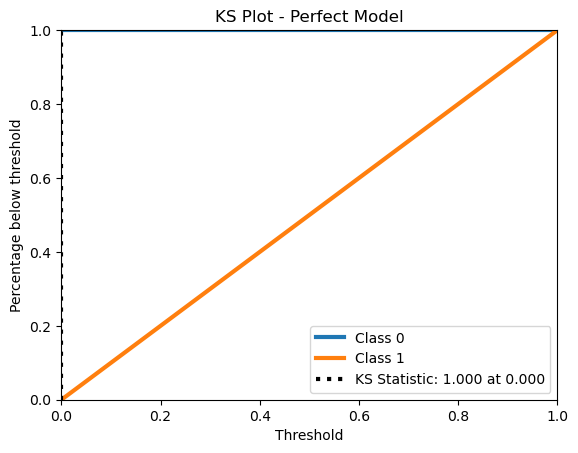

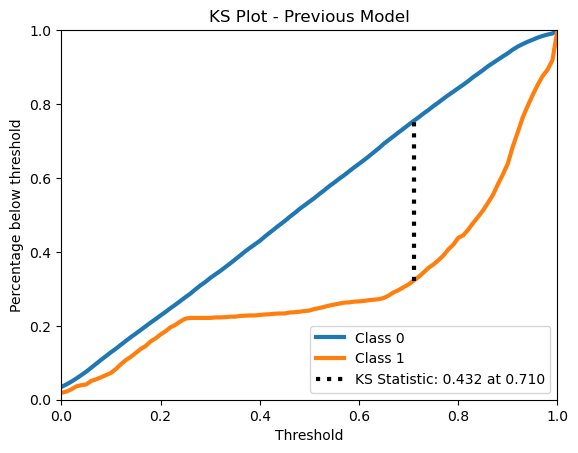

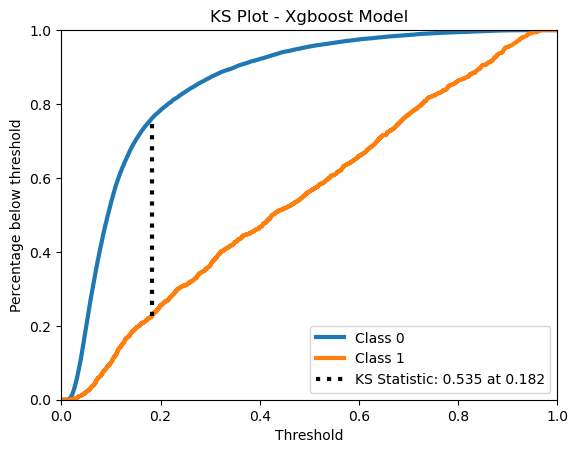

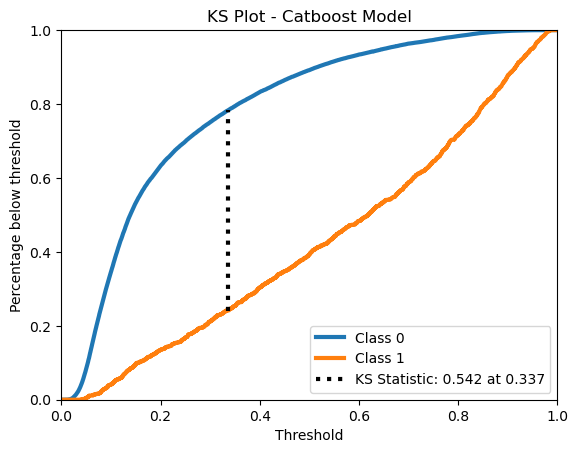

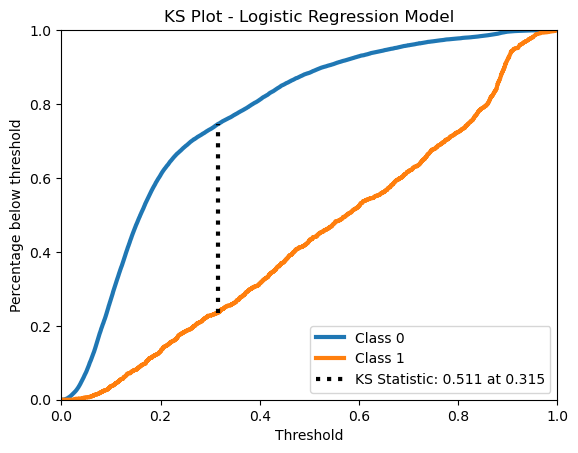

In [94]:
skplt.metrics.plot_ks_statistic(y_test, [[1-i,i] for i in y_test])
plt.title('KS Plot - Perfect Model');
skplt.metrics.plot_ks_statistic(y_test, [[1-i,i] for i in y_hat_prev])
plt.title('KS Plot - Previous Model');
skplt.metrics.plot_ks_statistic(y_test, y_hat_xgb_weighted)
plt.title('KS Plot - Xgboost Model');
skplt.metrics.plot_ks_statistic(y_test, y_hat_cat_weighted)
plt.title('KS Plot - Catboost Model');
skplt.metrics.plot_ks_statistic(y_test, y_hat_lgr_weighted)
plt.title('KS Plot - Logistic Regression Model');

### Curva de Lucro <a id="5"></a>

Nessa função profit_per_threshold, uma curva de lucro é criada considerando diferentes thresholds de classificação. A ideia principal é encontrar o threshold ótimo que maximiza o lucro esperado para o modelo de classificação.
O lucro de uma compra aprovada (Verdadeiros negativos) é de 10% do valor da transação, enquanto que o custo de deixar uma fraude ser aprovada (Falsos negativos) é de 100% do custo do produto

In [95]:
def profit_per_threshold(y_true, y_hat, monto, n_bins=50):
    TP_cost = 0
    TN_cost = .1
    FP_cost = 0
    FN_cost = -1.0
    profits_list = []

    cutoffs = np.linspace(0,1,n_bins)
    for cutoff in cutoffs:
        y_pred = (y_hat >= cutoff).astype(int)
        TP_monto = np.where((y_true == 1) & (y_pred == 1), monto, 0)
        TN_monto = np.where((y_true == 0) & (y_pred == 0), monto, 0)
        FP_monto = np.where((y_true == 0) & (y_pred == 1), monto, 0)
        FN_monto = np.where((y_true == 1) & (y_pred == 0), monto, 0)

        profit = np.sum(TP_cost*TP_monto) + np.sum(TN_cost*TN_monto) + np.sum(FP_cost*FP_monto) + np.sum(FN_cost*FN_monto)
        profits_list.append(profit)

    best_cutoff = cutoffs[np.argmax(profits_list)]
    return profits_list, best_cutoff

In [96]:
n_bins = 300
monto = X_test.monto
#monto = [1]*len(X_test)
profit_prev, cutoff_prev = profit_per_threshold(y_test, y_hat_prev, monto, n_bins)
profit_xgb, cutoff_xgb = profit_per_threshold(y_test, y_hat_xgb[:,1], monto, n_bins)
profit_cat, cutoff_cat = profit_per_threshold(y_test, y_hat_cat[:,1], monto, n_bins)
profit_lgr, cutoff_lgr = profit_per_threshold(y_test, y_hat_lgr[:,1], monto, n_bins)

In [97]:
fig = go.Figure()
x = np.linspace(0,100,n_bins)
fig.add_trace(go.Scatter(x=x, y=profit_prev, mode='lines', name=f'Previous Model'))
fig.add_trace(go.Scatter(x=x, y=profit_xgb, mode='lines', name=f'Xgboost Model'))
fig.add_trace(go.Scatter(x=x, y=profit_cat, mode='lines', name=f'Catboost Model'))
fig.add_trace(go.Scatter(x=x, y=profit_lgr, mode='lines', name=f'Logistic Regression Model'))

fig.update_layout(
        xaxis_title='Limiar',
        yaxis_title='Lucro',
        title='Curva de Lucro',
    )

In [98]:
print(f'Previous Model: Lucro máximo de R$ {round(max(profit_prev),2)} no limiar {int(cutoff_prev*100)}.')
print(f'Xgboost Model: Lucro máximo de R$ {round(max(profit_xgb), 2)} no limiar {int(cutoff_xgb*100)}.')
print(f'Catboost Model: Lucro máximo de R$ {round(max(profit_cat),2)} no limiar {int(cutoff_cat*100)}.')
print(f'Logistic regression Model: Lucro máximo de R$ {round(max(profit_lgr), 2)} no limiar {int(cutoff_lgr*100)}.')

Previous Model: Lucro máximo de R$ 48910.01 no limiar 73.
Xgboost Model: Lucro máximo de R$ 67148.0 no limiar 34.
Catboost Model: Lucro máximo de R$ 73533.28 no limiar 63.
Logistic regression Model: Lucro máximo de R$ 66619.97 no limiar 67.


In [99]:
profit_prev_full, cutoff_prev_full= profit_per_threshold(y, y_pre, X.monto)
fig = go.Figure()
x = np.linspace(0,100,n_bins)
fig.add_trace(go.Scatter(x=x, y=profit_prev, mode='lines', name=f'Previous Model'))

fig.update_layout(
        xaxis_title='Limiar',
        yaxis_title='Lucro',
        title='Curva de Lucro do modelo anterior para o dataset completo',
    )

In [100]:
print(f'Previous Model: Lucro máximo de R$ {round(max(profit_prev_full),2)} no limiar {int(cutoff_prev_full*100)}.')


Previous Model: Lucro máximo de R$ 264929.07 no limiar 75.


In [101]:
profit_xgb_weighted, cutoff_xgb_weighted = profit_per_threshold(y_test, y_hat_xgb_weighted[:,1], monto, n_bins)
profit_cat_weighted, cutoff_cat_weighted = profit_per_threshold(y_test, y_hat_cat_weighted[:,1], monto, n_bins)
profit_lgr_weighted, cutoff_lgr_weighted = profit_per_threshold(y_test, y_hat_lgr_weighted[:,1], monto, n_bins)

In [102]:
fig = go.Figure()
x = np.linspace(0,100,n_bins)
fig.add_trace(go.Scatter(x=x, y=profit_prev, mode='lines', name=f'Previous Model'))
fig.add_trace(go.Scatter(x=x, y=profit_xgb_weighted, mode='lines', name=f'Xgboost Model'))
fig.add_trace(go.Scatter(x=x, y=profit_cat_weighted, mode='lines', name=f'Catboost Model'))
fig.add_trace(go.Scatter(x=x, y=profit_lgr_weighted, mode='lines', name=f'Logistic Regression Model'))

fig.update_layout(
        xaxis_title='Limiar',
        yaxis_title='Lucro',
        title='Curva de Lucro - Amostras ponderadas',
    )

In [103]:
print(f'Previous Model: Lucro máximo de R$ {round(max(profit_prev),2)} no limiar {int(cutoff_prev*100)}.')
print(f'Xgboost Model: Lucro máximo de R$ {round(max(profit_xgb_weighted), 2)} no limiar {int(cutoff_xgb_weighted*100)}.')
print(f'Catboost Model: Lucro máximo de R$ {round(max(profit_cat_weighted),2)} no limiar {int(cutoff_cat_weighted*100)}.')
print(f'Logistic regression Model: Lucro máximo de R$ {round(max(profit_lgr_weighted), 2)} no limiar {int(cutoff_lgr_weighted*100)}.')

Previous Model: Lucro máximo de R$ 48910.01 no limiar 73.
Xgboost Model: Lucro máximo de R$ 69685.45 no limiar 25.
Catboost Model: Lucro máximo de R$ 73960.98 no limiar 49.
Logistic regression Model: Lucro máximo de R$ 66548.89 no limiar 50.


Como observado nas matrizes de confusão, houve uma redução no número de falsos negativos quando o modelo foi treinado dando mais peso às fraudes. O limiar foi definido como o ponto de maior lucro.

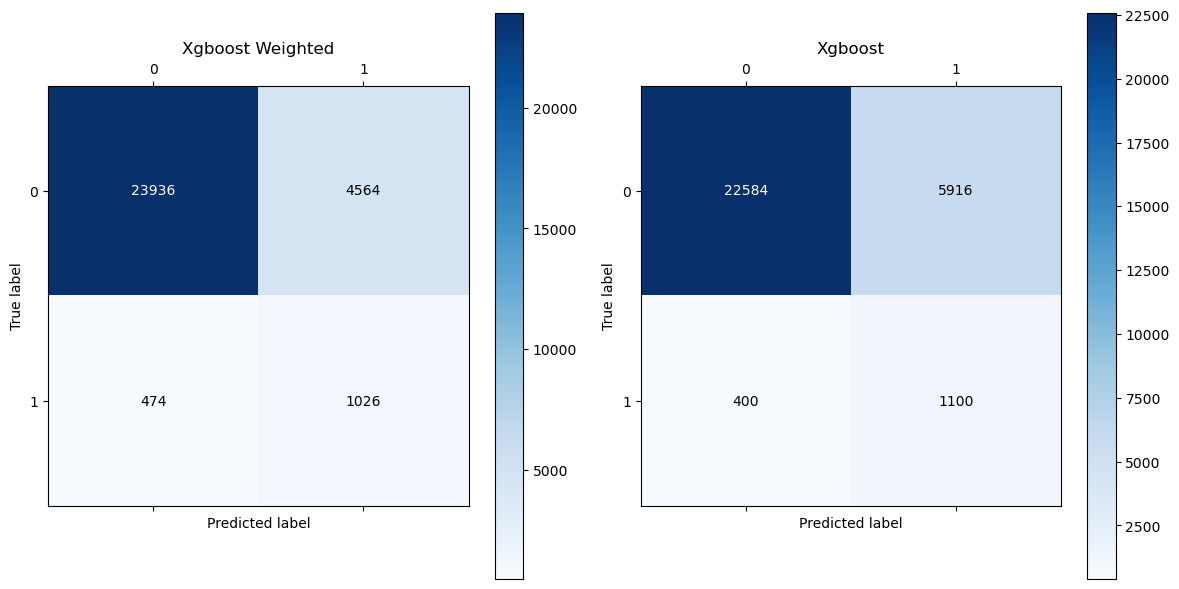

In [104]:
cm1 = m.confusion_matrix(y_test, y_hat_xgb_weighted[:,1]>=cutoff_xgb_weighted)
cm2 = m.confusion_matrix(y_test, y_hat_xgb[:,1]>=cutoff_xgb)

def plot_confusion_matrix(ax, cm, title):
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    plt.colorbar(ax.matshow(cm, cmap='Blues'))
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           ylabel='True label',
           xlabel='Predicted label')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2. else "black")

# Criação da figura e dos subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotagem das matrizes de confusão
plot_confusion_matrix(axs[0], cm1, title='Xgboost Weighted')
plot_confusion_matrix(axs[1], cm2, title='Xgboost')

plt.tight_layout()
plt.show();


### Rápido tempo de inferência <a id="6"></a>

Se o modelo precisar responder online, no menor tempo possível, aLguns ajustes podem ser feitos de maneira a acelerar o tempo de inferência.

#### Ajustar parâmetros sensíveis ao tempo de inferência

Para modelos based-trees usando boosting, como Xgboost e CatBoost, alguns parâmetros são:

1. **max_depth (profundidade máxima da árvore)**: Quanto mais profunda a árvore, mais complexas e demoradas serão as decisões de inferência. Limitar a profundidade da árvore pode acelerar a inferência.

2. **subsample (subamostragem por linha)**: Controla a proporção de observações usadas para treinar cada árvore. Reduzir o valor pode acelerar a inferência, mas pode prejudicar a precisão do modelo.

3. **colsample_bytree (subamostragem por coluna)**: Controla a proporção de características usadas para treinar cada árvore. Reduzir o valor pode acelerar a inferência, mas novamente pode afetar a precisão.


4. **n_estimators (número de árvores)**: Quanto mais árvores, mais complexo é o modelo e, portanto, mais tempo é necessário para fazer uma previsão.

5. **gamma**: Um parâmetro de regularização que controla se um nó será dividido com base na redução esperada na perda após a divisão. Reduzir isso pode levar a árvores mais rasas e, portanto, a inferências mais rápidas.


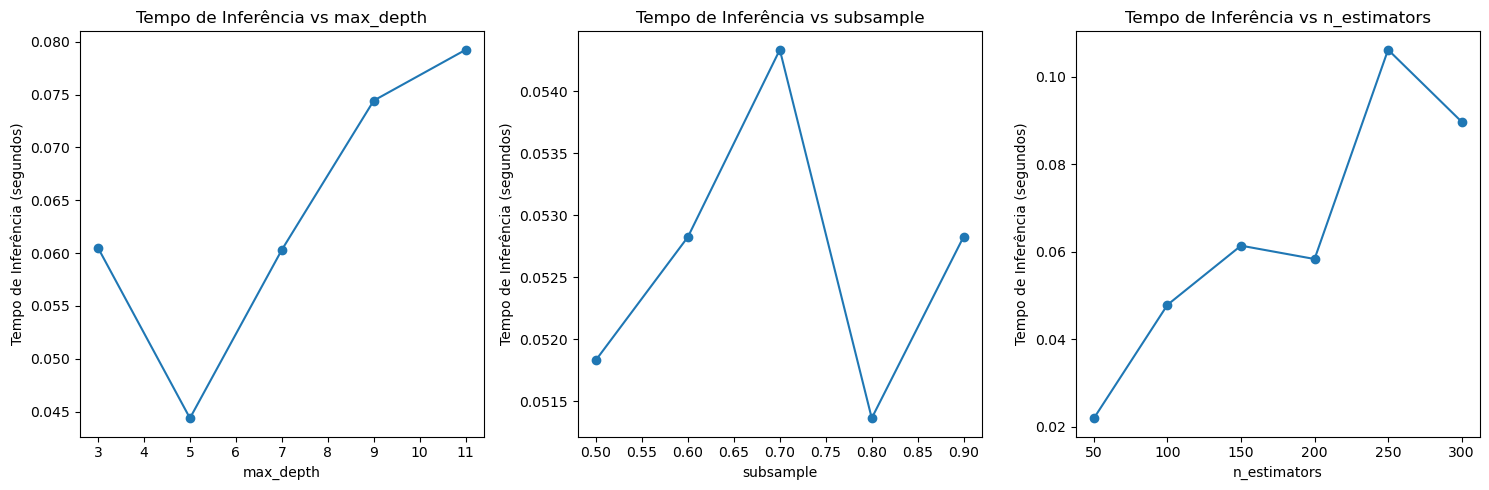

In [105]:
import time

# Defina faixas de valores para os parâmetros
max_depths = [3, 5, 7, 9, 11]
subsampling_rates = [0.5, 0.6, 0.7, 0.8, 0.9]
num_estimators = [50, 100, 150, 200, 250, 300]

# Lista para armazenar os tempos de inferência
inference_times_max_depth = []
inference_times_subsample = []
inference_times_estimators = []

# Função para medir o tempo de inferência
def measure_inference_time(model, X_test):
    start_time = time.time()
    model.predict(X_test)
    end_time = time.time()
    return end_time - start_time

# Configurações do subplot
num_rows = 1
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

# Plot para max_depth
for depth in max_depths:
    model = XGBClassifier(max_depth=depth, enable_categorical=True)
    model.fit(X_train_xgb, y_train)
    inference_time = measure_inference_time(model, X_test_xgb)
    inference_times_max_depth.append(inference_time)

axes[0].plot(max_depths, inference_times_max_depth, marker='o')
axes[0].set_title('Tempo de Inferência vs max_depth')
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('Tempo de Inferência (segundos)')

# Plot para subsample
for subsample_rate in subsampling_rates:
    model = XGBClassifier(subsample=subsample_rate, enable_categorical=True)
    model.fit(X_train_xgb, y_train)
    inference_time = measure_inference_time(model, X_test_xgb)
    inference_times_subsample.append(inference_time)

axes[1].plot(subsampling_rates, inference_times_subsample, marker='o')
axes[1].set_title('Tempo de Inferência vs subsample')
axes[1].set_xlabel('subsample')
axes[1].set_ylabel('Tempo de Inferência (segundos)')

# Plot para n_estimators
for n_estimator in num_estimators:
    model = XGBClassifier(n_estimators=n_estimator, enable_categorical=True)
    model.fit(X_train_xgb, y_train)
    inference_time = measure_inference_time(model, X_test_xgb)
    inference_times_estimators.append(inference_time)

axes[2].plot(num_estimators, inference_times_estimators, marker='o')
axes[2].set_title('Tempo de Inferência vs n_estimators')
axes[2].set_xlabel('n_estimators')
axes[2].set_ylabel('Tempo de Inferência (segundos)')

# Ajuste o layout
plt.tight_layout()

# Mostrar os gráficos
plt.show()

#### Feature Selection ou aplicar técnicas de redução de dimensionalidade (como PCA)

Ao reduzir o número de características, o tempo necessário para fazer previsões também é reduzido. Mas é essencial realizar uma avaliação cuidadosa dos efeitos da seleção de características no desempenho geral do modelo antes de implementá-la em produção. Em alguns casos, técnicas de redução de dimensionalidade, como PCA (Análise de Componentes Principais), podem ser mais apropriadas do que a simples seleção de características.

#### Fazer o deploy em serviços de cloud especializados, como o Sagemaker Endpoint

O SageMaker Endpoint permite que você implante seu modelo treinado em uma infraestrutura escalável e disponibilize uma API para fazer previsões em tempo real. Os endpoints do SageMaker são otimizados para oferecer baixa latência, garantindo que as previsões sejam entregues rapidamente em tempo real. Além disso, o SageMaker gerencia automaticamente a infraestrutura subjacente, permitindo que você dimensione automaticamente para atender às demandas de carga de trabalho variáveis.

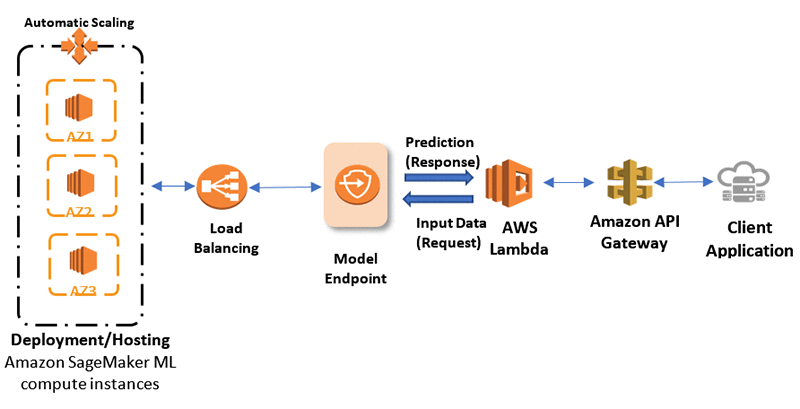

Como sugestão, segue uma arquitetura da AWS que pode ser utilizada para fazer inferência em tempo real e com baixa latência, no contexto de detecção de fraudes do Mercado Livre.

1. **Requisição ao API Gateway**:
   - Quando uma transação é realizada, uma requisição é feita ao API Gateway da AWS. O API Gateway atua como um ponto de entrada para as solicitações e permite que elas sejam roteadas para outros serviços da AWS, como AWS Lambda.

2. **AWS Lambda**:
   - O API Gateway encaminha a requisição para uma função AWS Lambda. Lambda é um serviço de computação sem servidor que executa o código em resposta a eventos, como uma solicitação HTTP.
   - A função Lambda neste caso é responsável por extrair as características (features) relevantes da transação. As características podem incluir informações como valor da transação, localização, histórico do cliente, entre outros.

3. **Endpoint do SageMaker**:
   - As características extraídas pela função Lambda são então enviadas para um endpoint do Amazon SageMaker. Este endpoint é onde o modelo de detecção de fraudes, previamente treinado, está hospedado.
   - O SageMaker é um serviço da AWS que facilita o treinamento, a hospedagem e a implantação de modelos de machine learning.
   - Ao receber as características da transação, o SageMaker executa o modelo de machine learning para fazer previsões sobre a probabilidade de fraude associada à transação.

4. **Geração do Output**:
   - O SageMaker gera como saída a probabilidade de fraude para a transação com base nas características fornecidas.
   - A saída do SageMaker pode ser uma pontuação de probabilidade contínua entre 0 e 1, indicando a probabilidade de fraude para a transação.

5. **Decisão de Fraude**:
   - Usando um determinado limiar de probabilidade, uma decisão é tomada para identificar se a transação é classificada como fraude ou não.
   - Por exemplo, se a pontuação de probabilidade exceder um determinado limiar (por exemplo, 0,5), a transação pode ser classificada como fraude. Caso contrário, é considerada legítima.

6. **Load Balancing e ML Compute Instances**:
   - Para lidar com um grande volume de solicitações de transação e garantir alta disponibilidade, pode-se utilizar load balancing. Isso distribui o tráfego entre várias instâncias de computação de machine learning (ML compute instances).
   - As instâncias de computação de ML (como instâncias EC2 otimizadas para machine learning) hospedam o endpoint do SageMaker e executam o modelo de detecção de fraudes em tempo real.

Essa arquitetura oferece um sistema escalável e eficiente para a detecção de fraudes em transações em tempo real, integrando vários serviços da AWS para processamento de solicitações, extração de características, inferência de modelo e tomada de decisão.